In [41]:
import os
import sys
sys.version
sys.version_info
print(sys.version)

sys.path.append('./functions/')
sys.path.append('../')
import paths

import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib
import csv
from matplotlib import cm

from importlib import reload

from scipy.signal import savgol_filter as savgol

#from sklearn.neighbors import KernelDensity
from scipy import stats
import peak_detector_fcn as pkdetect
import timeFractions_f as timeFracs
import spistogram_mat_f as spisto

%matplotlib inline

3.7.8 | packaged by conda-forge | (default, Nov 27 2020, 19:24:58) 
[GCC 9.3.0]


## READ IN THE DATA

### 0. make year fraction for earthquake data and UTC time (in a function)

### 1. organize events by date... resequence in panda
### 2. make the spistogram matrix
### 3. run the KDE
### 4. pick the peaks and resequence
### 5. plot

## Injection or other forcing data, ADD to plot: 
### 6. import injection data pickle.. 
### 7. trim both data sets to have same total time window
### 8. interpolate injection data at eq times for plotting
### 9. add to plot. 



In [42]:
# =====================================================
# read in the pickled panda that has the clustering results ! 

# station = 'AL4'
# path_to_pickle = '/Users/ben/Dropbox/10_ML/ML_data/Cats_w_Clusters/'

# #pickle_name = 'CATALOG_wData.pkl'
# pickle_name = 'CAT_wc_NW_AL4.pkl'

# =========================================
#%% load project variables: names and paths
# key = sys.argv[1]
#key = "Gorner_Events_TS_mac1"
# key = 'GeysersNW_BH_ub_dbox'
key = 'MIT_NER_BHdisk'
print(key)
reload(paths)
p = paths.returnp(key)
print(p)

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
pathFig         = p['pathFig']

if datasetID=='Dry':
    expt='Dry'
elif datasetID=='Water':
    expt = 'Wet'
    
# clusterPickleName = 'principalDf_full_Kopt5.pkl' # add this to paths ! 

clusterCSVname = 'principalDf_full_Kopt5.csv' # add this to paths ! 
# OR 
# the h5: 'MIT_NER_clusterCat.hdf5'


#%% make figure folder
# if not os.path.isdir(path_proj + "/postML_figures/"):
#     os.mkdir(path_proj + "/postML_figures/")
if not os.path.isdir(pathFig):
    os.mkdir(pathFig)

print('LOADING THE CSV!')
cat = pd.read_csv( path_proj + clusterCSVname )

#print('LOADING THE PICKLE!')
#cat = pd.read_pickle( path_proj + clusterPickleName )

#cat = pd.read_pickle('/home/ben/Dropbox/x02_MLseismology/03_ML_data/GEYSERS/GeysersNW/principalDf_full_Kopt4.pkl')


print(cat.columns)
cat.datetime = pd.to_datetime(cat.datetime)
n_evts = len(cat.datetime)
print('n_events = ', n_evts)

print(cat.datetime.iloc[0:5])
# start_date_eqs = [cat.year[0], cat.month[0], cat.day[0]]
# end_date_eqs = [cat.year.iloc[-1], cat.month.iloc[-1], cat.day.iloc[-1]]
# print(start_date_eqs)
# print(end_date_eqs)

MIT_NER_BHdisk
{'projName': 'MIT_NER', 'datasetID': 'Water', 'station': 'pzt01', 'channel': '01', 'path_top': '/media/ben/bup2020/Tiange_NER/', 'path_proj': '/media/ben/bup2020/Tiange_NER/Water/', 'outfile_name': 'SpecUFEx_out_MIT_NER_fngrs.h5', 'dataFile_name': 'MIT_NER_idWater_ch01.h5', 'subCatalog_Name': 'MIT_NER_idWater_ch01.h5_Sgrams_Subcatalog.hdf5', 'pathFig': '/media/ben/bup2020/Tiange_NER/Water/postML_figures/', 'path_WF': '/media/ben/bup2020/Tiange_NER/Water/', 'path_Cat': '/media/ben/bup2020/Tiange_NER/Water/', 'path_sgram': '/media/ben/bup2020/Tiange_NER/Water/spectrograms/', 'path_sgram_fig': '/media/ben/bup2020/Tiange_NER/Water/spectrogram_figures/'}
LOADING THE CSV!
Index(['Unnamed: 0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'event_ID', 'Cluster', 'SS', 'euc_dist',
       'datetime', 'day', 'depth', 'event_ID_orig', 'hour', 'lat', 'long',
       '

In [43]:
reload(timeFracs)
yearFrac,hourFrac = timeFracs.calc_YearFloat_HourFloat(cat)
print(yearFrac[0:5],hourFrac[2000:2005])

cat['YearFrac'] = yearFrac
cat['HourFrac'] = hourFrac

[2020.13595086 2020.13595451 2020.13595453 2020.13595454 2020.13595459] [3.01463194 3.03169694 3.03177056 3.04929306 3.0588825 ]


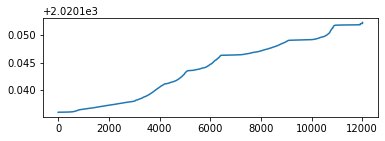

In [44]:
index = cat.index
yr_frac = cat.YearFrac

plt.subplot(2,1,1)
plt.plot(yearFrac)
#plt.title('BEWARE! THE DATES ARE NOT SEQUENTIAL! FIX AT PICKLE SOURCE!  ')

# # re-sort on time: 
# catR = cat.sort_values(['YearFrac'])
# catR = catR.reset_index(drop=True)

# # FIX THAT SEQUENCE !! eek ! 
# plt.subplot(2,1,2)
# plt.plot(catR.YearFrac)


## Whole sequence spistogram

2020.0


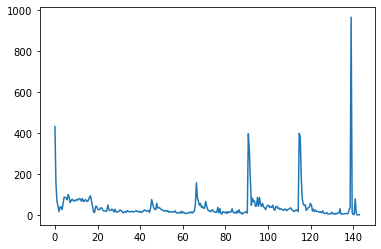

In [45]:
# initial histogram of times: 
print(np.floor(yearFrac[0]))
t_AEs_hr = (yearFrac-np.floor(yearFrac))*24*365.25
t_AEs_hr0 = t_AEs_hr-t_AEs_hr[0]
# make new column for the time you want to see in the plot ! 
cat['time_4plot'] = t_AEs_hr0

# ================
# histogram of AE times
#np.histogram(a, bins=10, range=None, normed=None, weights=None, density=None)[source]
histAll, bin_edgesAll = np.histogram(t_AEs_hr0, bins = 300, density=False)
time_hr0 = bin_edgesAll[0:-1]
#print(time_hr0[0:5])
plt.plot(time_hr0, histAll)

## Clusters output

In [46]:
reload(spisto)
NC=4
n_bins = 100
cluster_floats= np.linspace(1,NC,NC).tolist()
cluster_list = [int(x) for x in cluster_floats] 
print(cluster_list)
timeEvts_matAll, xgrid_spistoAll, ygrid_spistoAll = spisto.makeSpistoMatrix(cat,NC,n_bins,cluster_list)

print(xgrid_spistoAll[0,0:5])

[1, 2, 3, 4]
[0.         1.4467166  2.89343319 4.34014979 5.78686639]


## PLOT the spistogram untrimmed ! 

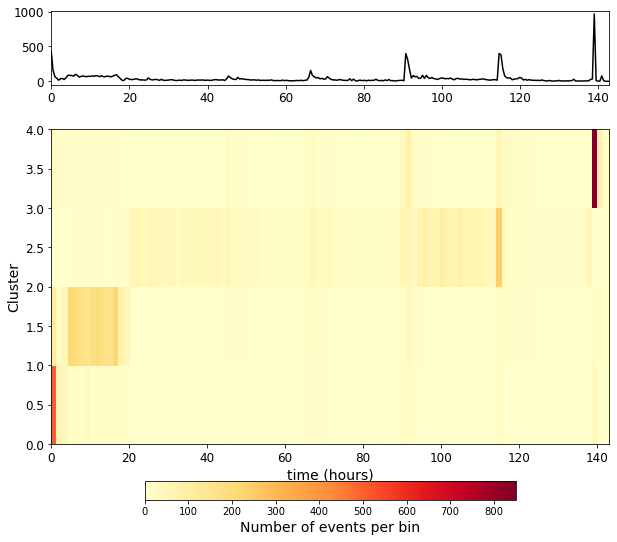

In [47]:
## PLOT THE SPISTOGRAM ! 
#fig = plt.figure(figsize=(10,9))

legendfontsize = 14
tickfontsize = 12

# refine the size ! make thinner ! 
fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1,5]},figsize=(10,9))


ax0.tick_params(axis='both', which='major', labelsize=tickfontsize)
ax0.plot(time_hr0, histAll,'k')
ax0.set_xlim([time_hr0[0],time_hr0[-1]])

# ============================
ax1.tick_params(axis='both', which='major', labelsize=tickfontsize)
# gotta fix the plot labels so it shows plt

plt.pcolormesh(xgrid_spistoAll,ygrid_spistoAll,timeEvts_matAll,cmap='YlOrRd')
#plt.pcolormesh(H,cmap='YlOrRd')
ax1.set_ylabel('Cluster', fontsize=legendfontsize)
bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
bar.set_label('Number of events per bin', fontsize=legendfontsize)

ax1.set_xlabel('time (hours)', fontsize=legendfontsize)

plt.axis('tight')

fig.savefig(pathFig+'spisto_whole.png')



# ZOOM IN before making the histograms 
(1) re-take the histogram, define a threshold, extract the time window start and endpoints <br>
(2) save those as tuples, and do new histograms, plot by cluster <br>
(3) redo those histograms by cluster, resequence by first occurrence (using KDE function or just savgol)

In [48]:
from scipy import interpolate as interpS

def interestingtimes(time,yvals,thold):
    roots = []
    x = time
    y = yvals
    v = thold

    cs = interpS.CubicSpline(x, y - v)
    v_roots = cs.roots()
    #v_roots = np.delete(v_roots,-1)
    for r in v_roots:
        if(r > 0):
            roots.append(r)
#           notes.append(v)

    # Sort the notes according to occurence
    # notes = np.asarray([x for (y,x) in sorted(zip(roots, notes))])
    times = np.asarray(sorted(roots))
    #print(times)
    
    # deal with cases for pos/neg zero crossing slope: 
    if y[0] > v:
        times_x = np.zeros(len(times)+1)
        times_x[1:] = times
        times = times_x

    durations = times[1:]-times[:-1]
    
#     times_trim = times[times <= time[-1]]
#     # #notes_trim = notes[times <= time[-1]]
#     durations = times_trim[1:]-times_trim[:-1]
    
#     # need to make durations the same length
#     durs = np.zeros(len(times_trim))
#     durs[0:-1] = durations
#     durs[-1] = time[-1] - times_trim[-1]
#     del durations
#     durations = durs
#     times = times_trim
    
    return times, durations, cs

[  0.           1.87126982   2.80294346  19.0076109   19.45402808
  22.16491265  24.53812303  26.71916791  43.84885017  50.07525821
  64.73703647  72.50112903  89.12622915 107.22270923 108.5418824
 111.69385427 112.93921546 117.11933279 117.87625742 121.57044944
 136.99071075 140.88624873 141.92403529 142.03766828 142.86715123]
25
[ 1.87126982  0.93167364 16.20466744  0.44641718  2.71088457  2.37321038
  2.18104487 17.12968226  6.22640805 14.66177826  7.76409256 16.62510012
 18.09648007  1.31917317  3.15197187  1.24536119  4.18011733  0.75692463
  3.69419203 15.42026131  3.89553799  1.03778656  0.11363299  0.82948295]
24
[  2.80294346  43.84885017  64.73703647  89.12622915 112.93921546
 117.87625742 136.99071075]
[16.20466744  6.22640805  7.76409256 18.09648007  4.18011733  3.69419203
  3.89553799]


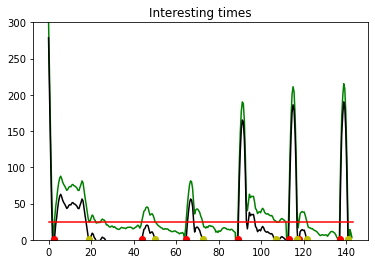

In [49]:
# Pick the "Interesting Times":

t_AEs_hr =  np.asarray(cat['time_4plot'])

if expt=='Dry':
    thold_nAE =  25. 
    winlen_max = 20.0
    winlen_min = 3.5
elif expt=='Wet':
    thold_nAE =  25.
    winlen_max = 20.0
    winlen_min = 3.5

# ================
# histogram of AE times
#np.histogram(a, bins=10, range=None, normed=None, weights=None, density=None)[source]
hist, bin_edges = np.histogram(t_AEs_hr0, bins = 300, density=False)

# smooth by savgol: 
windowlen = 11
polyorder = 3
hist_sm = savgol(hist,windowlen,polyorder, mode='nearest')

# find the times at which N is above the threshold, then take an interval before and after. 

times, durations, cspline = interestingtimes(bin_edges[0:-1],hist_sm,thold_nAE)
print(times)
print(len(times))
print(durations)
print(len(durations))
print(cspline)

# take every other value of times so only start times ! 
# MOVE THIS INTO THE FUNCTION FOR CLASS !! 
times_s = times[0::2]
durations_s = durations[0::2]

times = times_s[0:-1]
durations = durations_s


# pick min and max durations

times_x = times[durations<=winlen_max]
durations_x = durations[durations<=winlen_max]
times_x = times_x[durations_x>=winlen_min]
durations_x = durations_x[durations_x>=winlen_min]
print(times_x)
print(durations_x)

# =======================================
#plt.plot(bin_edges[0:-1],hist, 'k')
fg = plt.figure()
plt.plot(bin_edges[0:-1],hist_sm, 'g-')
plt.plot(bin_edges[0:-1],cspline(bin_edges[0:-1]), 'k-')
plt.plot([bin_edges[0],bin_edges[-1]],[thold_nAE,thold_nAE], 'r-')

#plt.plot(times,np.ones(len(times)), 'ro')
plt.plot(times_x,np.ones(len(times_x)), 'ro')
plt.plot(times_x+durations_x,np.ones(len(times_x)), 'yo')
plt.ylim([0,300])
plt.title('Interesting times')
fg.savefig(pathFig+'interestingTimes_select.png')

In [50]:
# now find the indexes of the events that have these times. 
#xtra = 0  # Wet
xtra = -1.1 # Dry
#fraction of an hour

starts = times_x - xtra
stops = times_x+durations_x + xtra

inttimes_inds = np.zeros((len(starts),2))
print(np.shape(inttimes_inds))

for i in range(len(starts)):
    # find event index at the starts and ends
    print(starts[i],stops[i])

    inttimes_inds[i,0] = np.argwhere(t_AEs_hr>starts[i]).flatten()[0]
    inttimes_inds[i,1] = np.argwhere(t_AEs_hr>stops[i]).flatten()[0]

print(inttimes_inds) #.flatten())



(7, 2)
3.9029434636750655 17.907610899763633
44.948850167111466 48.97525821493403
65.83703647275104 71.40112903279353
90.2262291536677 106.12270922666718
114.03921545856164 116.01933278893225
118.9762574158204 120.4704494411535
138.0907107473253 139.78624873250982
[[  832.  3032.]
 [ 4186.  4558.]
 [ 5092.  5793.]
 [ 6408.  8645.]
 [ 9060. 10040.]
 [10320. 10477.]
 [10884. 11914.]]


In [51]:
reload(spisto)

NC=4
cluster_floats= np.linspace(1,NC,NC).tolist()
cluster_list = [int(x) for x in cluster_floats] 

# spistogram bins
n_bins = 300
#print(range(len(inttimes_inds)))

with h5py.File('ITcats','w') as ITcats: 
    for itind in range(len(inttimes_inds)):
        # define the subcatalogs
        row = itind
        print(row)
        minind = int(inttimes_inds[row,0]) #+3)
        maxind = int(inttimes_inds[row,1]) #-40)
        
        # extract from the dataframe ! 
        exec(f'cat_{row} = cat.iloc[minind:maxind]')
        
        #h5 
        exec(f'ITcats.create_group(name= "ITcat{row}")') #, data=newcat['{key}'][...])")')
        
        #exec(f'subtimes_{row} = t_AEs_hr[minind:maxind]')
        exec(f'subtimes_{row} = cat.time_4plot[minind:maxind]')
        #exec(f'print(subtimes_{row})')
        exec(f'hist, bin_edges = np.histogram(subtimes_{row}, bins = {n_bins}, density=False)')
        # spistogram
        exec(f'timeEvts_mat, xgrid_spisto, ygrid_spisto = spisto.makeSpistoMatrix(cat_{row},NC,n_bins,cluster_list)')
        
        exec(f'ITcats.create_dataset(name= "ITcat{row}/subtimes", data=subtimes_{row}[...])')
        exec(f'ITcats.create_dataset(name= "ITcat{row}/hist", data=hist[...])')
        exec(f'ITcats.create_dataset(name= "ITcat{row}/bin_edges", data=bin_edges[...])')
        exec(f'ITcats.create_dataset(name= "ITcat{row}/timeEvts_mat", data=timeEvts_mat[...])')
        exec(f'ITcats.create_dataset(name= "ITcat{row}/xgrid_spisto", data=xgrid_spisto[...])')
        exec(f'ITcats.create_dataset(name= "ITcat{row}/ygrid_spisto", data=ygrid_spisto[...])')
        
    print(ITcats.keys())
    print(ITcats['ITcat0'].keys())

#plt.plot(bin_edges[0:-1],hist, 'k')



#exec(f"oldcat.create_dataset(name= '{key}', data=newcat['{key}'][...])")

0
1
2
3
4
5
6
<KeysViewHDF5 ['ITcat0', 'ITcat1', 'ITcat2', 'ITcat3', 'ITcat4', 'ITcat5', 'ITcat6']>
<KeysViewHDF5 ['bin_edges', 'hist', 'subtimes', 'timeEvts_mat', 'xgrid_spisto', 'ygrid_spisto']>


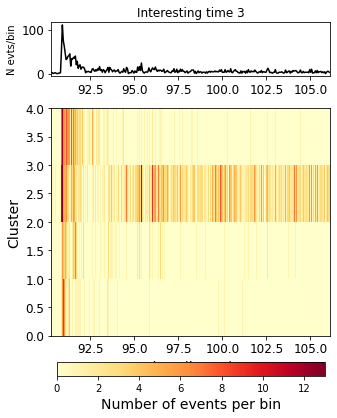

In [52]:


## PLOT THE SPISTOGRAM ! 
#fig = plt.figure(figsize=(10,9))

legendfontsize = 14
tickfontsize = 12

row = 3 

with h5py.File('ITcats','r') as ITcats: 
    exec(f'xgrid_spisto = np.asarray(ITcats["ITcat{row}/xgrid_spisto"][...])')
    exec(f'ygrid_spisto = np.asarray(ITcats["ITcat{row}/ygrid_spisto"][...])')
    exec(f'timeEvts_mat = np.asarray(ITcats["ITcat{row}/timeEvts_mat"][...])')
    exec(f'hist = np.asarray(ITcats["ITcat{row}/hist"][...])')
    exec(f'bin_edges = np.asarray(ITcats["ITcat{row}/bin_edges"][...])')


fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1,5]},figsize=(5,6.5))

ax0.tick_params(axis='both', which='major', labelsize=tickfontsize)
ax0.plot(bin_edges[0:-1],hist, 'k')
ax0.set_ylabel('N evts/bin')
ax0.set_xlim((bin_edges[0],bin_edges[-1]))
exec(f'ax0.set_title("Interesting time {row}")')


# ==================================
ax1.tick_params(axis='both', which='major', labelsize=tickfontsize)

plt.pcolormesh(xgrid_spisto,ygrid_spisto,timeEvts_mat,cmap='YlOrRd')
ax1.set_ylabel('Cluster', fontsize=legendfontsize)
bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
bar.set_label('Number of events per bin', fontsize=legendfontsize)

ax1.set_xlabel('time (hours)', fontsize=legendfontsize)
plt.axis('tight')

exec(f'fig.savefig(pathFig + "spisto_subIT{row}.png")')


## MAKE pretty plot

In [53]:
# Load the mechanical data ! 

with h5py.File(path_proj+'mechanicalData.h5', 'r') as mechdata: 

    Sig_diff_MPa = np.asarray(mechdata['Sig_diff_MPa'])
    Strain_ax = np.asarray(mechdata['Strain_ax'])
    t_def_hr = np.asarray(mechdata['t_def_hr'])
    
# mechdata.create_dataset('Temp', data=Temp)
# mechdata.create_dataset('t_def', data=t_def)
# mechdata.create_dataset('Disp_mm', data=Disp_mm)  
# mechdata.create_dataset('Date', data=Date)
# mechdata.create_dataset('RockType', data=RockType)
# mechdata.create_dataset('P_conf_MPa', data=P_conf_MPa)
# mechdata.create_dataset('P_pore_MPa', data=P_pore_MPa)
# mechdata.create_dataset('SampleDiameter_mm', data=SampleDiameter)
# mechdata.create_dataset('SampleLength_mm', data=SampleLength)

In [54]:
import matplotlib._color_data as mcd
# https://xkcd.com/color/rgb/
#mcd['xkcd']['royal blue']
xblue = mcd.XKCD_COLORS["xkcd:royal blue"]
print(xblue)
xgreen = mcd.XKCD_COLORS["xkcd:grass green"]
print(xgreen)

#0504aa
#3f9b0b


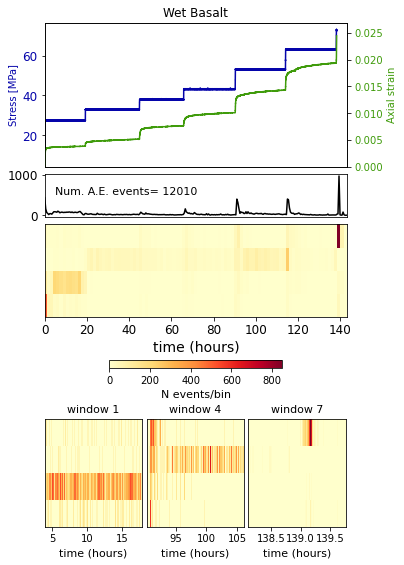

In [58]:
prtyfig = plt.figure(figsize=(6,10))


vgap = 0.01 
# stress-strain plot 
L0 = 0.15 
B0 = 0.6
W0 = 0.7
H0 = 0.2

# histogram_all 
H1 = 0.3*H0
L1 = L0 
B1 = B0-H1-vgap
W1 = W0


# SPISTogram_all 
H2 = 0.2
L2 = L0 
B2 = B1-H2-vgap
W2 = W0


legendfontsize = 14
tickfontsize = 12


# ============================================
# stress-strain
ax0 = plt.axes([L0,B0,W0,H0])

t_def_hr0 = t_def_hr-t_def_hr[0]

if expt=='Dry':
    tfit0 = -23  # Dry
    tfitEnd = 140 # Dry
    ax0.set_title('Dry Basalt')
elif expt=='Wet':
    tfit0 = 0  # Water
    tfitEnd = t_def_hr0[-1]+5.0 # Water
    ax0.set_title('Wet Basalt')

ax0.set_xticks([])
color = xblue # 'tab:blue'
ax0.tick_params(axis='both', which='major', labelsize=tickfontsize)
ax0.plot(t_def_hr0, Sig_diff_MPa,'k', color=color)
ax0.tick_params(axis='y', labelcolor=color)
ax0.set_ylabel('Stress [MPa]', color=color)
ax0.set_xlim([tfit0,tfitEnd])

ax0b = ax0.twinx() 
color = xgreen #'tab:green'
ax0b.plot(t_def_hr0, Strain_ax,'k', color=color)
ax0b.tick_params(axis='y', labelcolor=color)
ax0b.set_ylabel('Axial strain', color=color)
ax0b.set_xlim([tfit0,tfitEnd])
ax0b.set_ylim([0,1.1*Strain_ax[-1]])

# ============================
# histogram
ax1 = plt.axes([L1,B1,W1,H1])

ax1.set_xticks([])
ax1.tick_params(axis='both', which='major', labelsize=tickfontsize)
ax1.plot(time_hr0, histAll,'k')
ax1.set_xlim([time_hr0[0],time_hr0[-1]])
if expt=='Dry':
    ax1.text(5,1500,f'Num. A.E. events= {len(t_AEs_hr0)}', fontsize=legendfontsize-3 )
elif expt=='Wet':
    ax1.text(5,500,f'Num. A.E. events= {len(t_AEs_hr0)}', fontsize=legendfontsize-3 )



# ============================
# SPISTOgram
ax2 = plt.axes([L2,B2,W2,H2])
ax2.tick_params(axis='both', which='major', labelsize=tickfontsize)
# gotta fix the plot labels so it shows plt

plt.pcolormesh(xgrid_spistoAll,ygrid_spistoAll,timeEvts_matAll,cmap='YlOrRd')
#plt.pcolormesh(H,cmap='YlOrRd')
#ax2.set_ylabel('Cluster', fontsize=legendfontsize)
bar = plt.colorbar(orientation='horizontal',fraction=0.06, pad=0.3) #, anchor=(0.5,3))
bar.set_label('N events/bin', fontsize=legendfontsize-3)

ax2.set_xlabel('time (hours)', fontsize=legendfontsize)
ax2.set_yticks([])
plt.axis('tight')


# sub-SPISTograms
drop = 0.22
wdiv = 3.1
wgap = 0.01
# ----------------
L3 = L0 
B3 = B2-drop
H3 = 0.15
W3 = W0/wdiv

# L3b = 0.2 
# B3b = B2-drop
# H3b = 0.15
# W3b = W0/4.0

# ----------------
L4 = L3+W3+wgap
B4 = B2-drop
H4 = 0.15
W4 = W0/wdiv

# L4b = 0.2 
# B4b = B2-drop
# H4b = 0.15
# W4b = W0/4.0

# ----------------
L5 = L4+W3+wgap 
B5 = B2-drop
H5 = 0.15
W5 = W0/wdiv

# L5b = 0.2 
# B5b = B2-drop
# H5b = 0.15
# W5b = W0/4.0

if expt=='Dry':
    rows = [0,2,3]
elif expt=='Wet':
    rows = [0,3,6]

# ============================
# sub-SPISTOgram 1 
row = rows[0]

with h5py.File('ITcats','r') as ITcats: 
    exec(f'xgrid_spisto = np.asarray(ITcats["ITcat{row}/xgrid_spisto"][...])')
    exec(f'ygrid_spisto = np.asarray(ITcats["ITcat{row}/ygrid_spisto"][...])')
    exec(f'timeEvts_mat = np.asarray(ITcats["ITcat{row}/timeEvts_mat"][...])')
    exec(f'hist = np.asarray(ITcats["ITcat{row}/hist"][...])')
    exec(f'bin_edges = np.asarray(ITcats["ITcat{row}/bin_edges"][...])')

# ax3b = plt.axes([L3b,B3b,W3b,H3b])

# ax3b.tick_params(axis='both', which='major', labelsize=tickfontsize)
# ax3b.plot(bin_edges[0:-1],hist, 'k')
# ax3b.set_ylabel('N evts/bin')
# ax3b.set_xlim((bin_edges[0],bin_edges[-1]))

# =================================
ax3 = plt.axes([L3,B3,W3,H3])
#ax3.tick_params(axis='both', which='major', labelsize=tickfontsize)
plt.pcolormesh(xgrid_spisto,ygrid_spisto,timeEvts_mat,cmap='YlOrRd')
# ax1.set_ylabel('Cluster', fontsize=legendfontsize)
# bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
# bar.set_label('Number of events per bin', fontsize=legendfontsize)
ax3.set_xlabel('time (hours)', fontsize=legendfontsize-3)
ax3.set_yticks([])
ax3.set_title(f'window {row+1}', fontsize=legendfontsize-3)
plt.axis('tight')

# ============================
# sub-SPISTOgram 2 
row = rows[1]

with h5py.File('ITcats','r') as ITcats: 
    exec(f'xgrid_spisto = np.asarray(ITcats["ITcat{row}/xgrid_spisto"][...])')
    exec(f'ygrid_spisto = np.asarray(ITcats["ITcat{row}/ygrid_spisto"][...])')
    exec(f'timeEvts_mat = np.asarray(ITcats["ITcat{row}/timeEvts_mat"][...])')
    exec(f'hist = np.asarray(ITcats["ITcat{row}/hist"][...])')
    exec(f'bin_edges = np.asarray(ITcats["ITcat{row}/bin_edges"][...])')

# ax3b = plt.axes([L3b,B3b,W3b,H3b])

# ax3b.tick_params(axis='both', which='major', labelsize=tickfontsize)
# ax3b.plot(bin_edges[0:-1],hist, 'k')
# ax3b.set_ylabel('N evts/bin')
# ax3b.set_xlim((bin_edges[0],bin_edges[-1]))

# =================================
ax4 = plt.axes([L4,B4,W4,H4])
#ax3.tick_params(axis='both', which='major', labelsize=tickfontsize)
plt.pcolormesh(xgrid_spisto,ygrid_spisto,timeEvts_mat,cmap='YlOrRd')
# ax1.set_ylabel('Cluster', fontsize=legendfontsize)
# bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
# bar.set_label('Number of events per bin', fontsize=legendfontsize)
ax4.set_xlabel('time (hours)', fontsize=legendfontsize-3)
ax4.set_yticks([])
ax4.set_title(f'window {row+1}', fontsize=legendfontsize-3)
plt.axis('tight')

# ============================
# sub-SPISTOgram 2 
row = rows[2]


with h5py.File('ITcats','r') as ITcats: 
    exec(f'xgrid_spisto = np.asarray(ITcats["ITcat{row}/xgrid_spisto"][...])')
    exec(f'ygrid_spisto = np.asarray(ITcats["ITcat{row}/ygrid_spisto"][...])')
    exec(f'timeEvts_mat = np.asarray(ITcats["ITcat{row}/timeEvts_mat"][...])')
    exec(f'hist = np.asarray(ITcats["ITcat{row}/hist"][...])')
    exec(f'bin_edges = np.asarray(ITcats["ITcat{row}/bin_edges"][...])')

# ax3b = plt.axes([L3b,B3b,W3b,H3b])

# ax3b.tick_params(axis='both', which='major', labelsize=tickfontsize)
# ax3b.plot(bin_edges[0:-1],hist, 'k')
# ax3b.set_ylabel('N evts/bin')
# ax3b.set_xlim((bin_edges[0],bin_edges[-1]))

# =================================
ax5 = plt.axes([L5,B5,W5,H5])
#ax3.tick_params(axis='both', which='major', labelsize=tickfontsize)
plt.pcolormesh(xgrid_spisto,ygrid_spisto,timeEvts_mat,cmap='YlOrRd')
# ax1.set_ylabel('Cluster', fontsize=legendfontsize)
# bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
# bar.set_label('Number of events per bin', fontsize=legendfontsize)
ax5.set_xlabel('time (hours)', fontsize=legendfontsize-3)
ax5.set_yticks([])
ax5.set_title(f'window {row+1}', fontsize=legendfontsize-3)
plt.axis('tight')


prtyfig.savefig(pathFig+'ALLshiny.png', dpi=260)


# PLOT BY STRESS ! 
(1) interpolate stress and strain at each event time, add to catalog. 
(2) replot those above by stress, strain, dissipation or work, slid dissipation or work: (sig-sig0)*strain

In [ ]:
# load the mechanical data and time windows. interpolate by stress... 

mech_data = 

In [ ]:
# pick the time window to look at: 
ind_end = len(cat.year)-1
print(ind_end)
print(cat.year[0],cat.year.loc[ind_end])
print(cat.year[0],cat.year.iloc[ind_end])

#print(cat.year[::300])
# https://stackoverflow.com/questions/18327624/find-elements-index-in-pandas-series
# myseries[myseries == 7].index[0]

ind_start = cat.year[cat.year==2012][cat.month==1][cat.day==1].index[0] #[cat.day==1].index[0] # add month, day as more logicals()
ind_end = cat.year[cat.year==2014][cat.month==12][cat.day==31].index[0] #[cat.day==1].index[0] # add month, day as more logicals()

print('start index = ',ind_start,cat.year[ind_start], cat.month[ind_start], cat.day[ind_start])
print('end index = ', ind_end, cat.year[ind_end], cat.month[ind_end], cat.day[ind_end])

ind_start_mo = int(np.round(np.interp(ind_start,np.linspace(1,n_evts),np.linspace(1,n_months))))
ind_end_mo = int(np.round(np.interp(ind_end,np.linspace(1,n_evts),np.linspace(1,n_months))))
print(ind_start_mo,ind_end_mo)
ind_start_mo = 0
ind_end_mo = ind_end_mo

#print(len(time_yearfrac_interp))

In [ ]:
# (BH: I THINK THIS IS OUTDATED== DROPNAN IN PANDAS TAKES CARE OF THIS )


#######################
#######################
#######################
NbStates_HMM = 15

# make sure these match ! 
NbClusters = 5
Events_Clusters = np.squeeze(np.array(cat.Cluster))
print(Events_Clusters)
print(type(Events_Clusters))
print(Events_Clusters.shape)
print(np.max(Events_Clusters))
# set nan to zero

# bbb = pd.isnull(Events_Clusters)
# print(bbb)
# Events_Clusters[bbb] = 0
# print(len(bbb))

# print(Events_Clusters)
# np.isnan fails on object arrays such as those that come out of pandas, even if converted to numpy arrays:
# https://stackoverflow.com/questions/36000993/numpy-isnan-fails-on-an-array-of-floats-from-pandas-dataframe-apply
#bbb = np.isnan(Events_Clusters)
#Events_Clusters[bbb] = 0
#b = np.where(np.isnan(a), 0, a)
#Events_Clusters = np.where(np.isnan(Events_Clusters), 0, Events_Clusters)
#Events_Clusters_nonan = np.num_to_nan(Events_Clusters)

#######################
#######################
#######################

# #### EQ DATA
# Events_Date = np.array(cat.TimeStamp)

# # # set origin of time
# Events_Date = Events_Date - Time0

# #### GET DISTRIBUTIONS
# for NumCluster in range(1,NbClusters+1):
#     exec('dateCl' + str(NumCluster) + ' = []')

# # fill in (for plotting mean & std)
# for elem in range(0,len(Events_Date)):
#     CurrentCluster = Events_Clusters[elem]
#     if CurrentCluster == 0:
#         1
#     else:
#         eval('dateCl' + str(int(Events_Clusters[elem])) + '.append(Events_Date[elem])')

# for NumCluster in range(1,NbClusters+1):
#     exec('dateCl' + str(NumCluster) + ' = np.array(dateCl' + str(NumCluster) + ')')

In [ ]:
# moved peak detector functions to a different file "peak_detector.py"  used in the KDE

# positions is for plotting? number of months !
positions = np.linspace(Events_Date[0],Events_Date[-1],n_months)
#positions = np.linspace(YearFrac[0],YearFrac[-1],n_months)
#positions_36 = np.linspace(Events_Date[0],Events_Date[-1],36)

ListOfValidArrays = []
    
THRESHOLD = 150 # if cluster has less than THRESHOLD items, discard this cluster
# was 200 for 46000 events ! 

MAX = 0 # for plot
for NumCluster in range(1,NbClusters+1):
    exec('CurrentDates = dateCl' + str(NumCluster))
    print('number of events in cluster ', str(NumCluster),': ', len(CurrentDates))
    if len(CurrentDates) < THRESHOLD:
        pass
    else:
        exec('kernelCl' + str(NumCluster) + ' = stats.gaussian_kde(dateCl' + str(NumCluster) + ')')
        ListOfValidArrays.append(NumCluster)
        exec('MAX = max(MAX,np.amax(kernelCl' + str(NumCluster) + '(positions)))')

for NumCluster in ListOfValidArrays:
    # find peaks
    exec('K = kernelCl' + str(NumCluster) + '(positions)')
    #exec('K_36 = kernelCl' + str(NumCluster) + '(positions_36)')
    mph = np.amax(K)/2
    exec('peaksCl' + str(NumCluster) + ' = pkdetect.detect_peaks(K, mph=mph)')

## plot KDE

In [ ]:
#DirOut = '/home/pate/Dropbox/RISE_project/0_PAPER/new_figs_arthur/' + str(NbStates_HMM) + 'states/' + STATION + '/KDE_xaxiswith300bins/'
#DirOut = '/Users/ben/githole/machine_listening/' + str(NbStates_HMM) + 'states/' + STATION + '/KDE_xaxiswith300bins/'

# font sizes
axislabelfontsize = 12
axistickfontsize = 12
legendfontsize = 9

# colormap
cm_kde = plt.get_cmap('jet')

# figure
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.tick_params(axis='both', which='major', labelsize=axistickfontsize)

# plot monthstones (# vertical lines for each month-- replate with seasons?)
#for ind in range(n_months): #[0,6,12,18,24,30,35]:
#    ax1.plot([Time_MonthsInSeconds[ind],Time_MonthsInSeconds[ind]],[0, MAX],color=[.7,.7,.7],linestyle='-',alpha=.8)

# plot kernels
ReNumCluster = 1
for NumCluster in ListOfValidArrays:
    #print(NumCluster)
    C = cm_kde(ReNumCluster/len(ListOfValidArrays))
    eval('ax1.plot(positions,kernelCl' + str(NumCluster) + '(positions), color=C, linewidth=3, \
        label=\'C' + str(ReNumCluster) + '\')')
    eval('ax1.plot(positions[peaksCl' + str(NumCluster) + '],kernelCl' + str(NumCluster) + '(positions)[peaksCl' + str(NumCluster) + '],\'xr\')')
    ReNumCluster+=1

plt.ylim([0,MAX])

# for plotting the legend in columns...
if len(ListOfValidArrays) < 6:
    ncols = 1
elif len(ListOfValidArrays) < 9:
    ncols = 2
elif len(ListOfValidArrays) == 9:
    ncols = 3
elif len(ListOfValidArrays) == 10:
    ncols = 2
elif len(ListOfValidArrays) > 10:
    ncols = 3
elif len(ListOfValidArrays) > 15:
    ncols = 4

plt.legend(loc='best',fontsize=legendfontsize, ncol=ncols, handletextpad=0.3, labelspacing=.4, columnspacing=1)
plt.ylabel('Density of events',fontsize=axislabelfontsize)
# xticklabels = ['01/2012','','','','','','07/2012','','','','','', \
#               '01/2013','','','','','','07/2013','','','','','', \
#               '01/2014','','','','','','07/2014','','','','','12/2014']
# plt.xticks([k for k in Months],xticklabels,fontsize=axistickfontsize)
#plt.xlabel('Time (months)',fontsize=axislabelfontsize)
#plt.grid(alpha=0.2)

# # plot injection
# ax2 = ax1.twinx()
# ax2.tick_params(axis='both', which='major', labelsize=axistickfontsize)
# ax2.plot(Time_MonthsInSeconds,Injection/10**6,'k--',linewidth=2)
# plt.ylabel('Water injection (x $10^9$ kg)',fontsize=axislabelfontsize)

plt.xlim([positions[0],positions[-1]])
plt.xlabel('Time (months)',fontsize=axislabelfontsize)
plt.grid(alpha=.2)

# fig.savefig(DirOut + 'KDE_' + str(NbClusters) + 'C_' + str(NbStates_HMM) + 'states' + '.svg')
# fig.savefig(DirOut + 'KDE_' + str(NbClusters) + 'C_' + str(NbStates_HMM) + 'states' + '_PEAKS.png')

#fig.savefig('KDE_' + str(NbClusters) + 'C_' + str(NbStates_HMM) + 'states' + '_PEAKS.png')

## Compute correlations between dates & injection

In [ ]:
# # hmmm not sure this is right.. .

# print(positions.shape,Injection.shape)
# dx = int(np.round(len(Injection)/len(positions)))
# Injection_subsam = Injection[:-2*dx:dx]
# print(len(Injection_subsam))

# ReNumCluster = 1
# for NumCluster in ListOfValidArrays:
#     command = 'CORR = np.corrcoef(kernelCl' + str(NumCluster) + '(positions),Injection_subsam)'
#     print(command)
#     exec(command)
#     #exec('CORR = np.corrcoef(kernelCl' + str(NumCluster) + '(positions),Injection)')
#     print('\t\t Corr. between Cl' + str(ReNumCluster) + ' & inj.: ' + str(CORR[0,1]))
#     ReNumCluster += 1

## Sort clusters

In [ ]:
Locs1stMax = []

for NumCluster in ListOfValidArrays:
    exec('Locs1stMax.append(peaksCl' + str(NumCluster) + '[0])')

print('Location of first peak for clusters ' + str(ListOfValidArrays) + ': ' + str(Locs1stMax))
NewOrderClusters = np.argsort(Locs1stMax)[::-1]

SortedListOfValidArrays = []
for N in NewOrderClusters:
    SortedListOfValidArrays.append(ListOfValidArrays[N])

print('New ordering of clusters: ' + str(SortedListOfValidArrays))

## Plot spistograms

In [ ]:
#DirOut = '/home/pate/Dropbox/RISE_project/0_PAPER/new_figs_arthur/' + str(NbStates_HMM) + 'states/' + STATION + '/Spisto/'

# CALCULATES THE HISTOGRAMS FOR EACH CLUSTER
Months = np.arange(1,n_months+1,1)
# Define bins / bin edges (from start time to end time, NbBins equal-width bins)
NbBins = n_months # 1 bin a month

TimeSpan = TimeEnd-Time0
BinWidth = TimeSpan/NbBins

BinEdges = []
for NumBin in range(0,NbBins+1):
    BinEdges.append(NumBin*BinWidth)
    
BinCenters = []    
for NumEdge in range(1,len(BinEdges)):
    BinCenters.append((BinEdges[NumEdge]+BinEdges[NumEdge-1])/2)
    
# Compute the histogram for each cluster (data = date)
for NCluster in ListOfValidArrays:
    exec('histC' + str(NCluster) + ', binsC' + str(NCluster) + ' = np.histogram(dateCl' + str(NCluster) + ', bins=BinEdges)')

# Join histograms into a matrix (This section to be run first, sorts clusters from 1 to 10)
H = np.zeros([len(NewOrderClusters),NbBins])
k = 0
for N in SortedListOfValidArrays:
    exec('H[k,:] = histC' + str(N))
    k+=1
print(len(Months))

#print(H)

In [ ]:
# pick the time window to look at: 
ind_end = len(cat.year)-1
print(ind_end)
print(cat.year[0],cat.year.loc[ind_end])
print(cat.year[0],cat.year.iloc[ind_end])

#print(cat.year[::300])
# https://stackoverflow.com/questions/18327624/find-elements-index-in-pandas-series
# myseries[myseries == 7].index[0]

ind_start = cat.year[cat.year==2012][cat.month==1][cat.day==1].index[0] #[cat.day==1].index[0] # add month, day as more logicals()
ind_end = cat.year[cat.year==2014][cat.month==12][cat.day==31].index[0] #[cat.day==1].index[0] # add month, day as more logicals()

print('start index = ',ind_start,cat.year[ind_start], cat.month[ind_start], cat.day[ind_start])
print('end index = ', ind_end, cat.year[ind_end], cat.month[ind_end], cat.day[ind_end])

ind_start_mo = int(np.round(np.interp(ind_start,np.linspace(1,n_evts),np.linspace(1,n_months))))
ind_end_mo = int(np.round(np.interp(ind_end,np.linspace(1,n_evts),np.linspace(1,n_months))))
print(ind_start_mo,ind_end_mo)
ind_start_mo = 0
ind_end_mo = ind_end_mo

#print(len(time_yearfrac_interp))

In [ ]:
len(ListOfValidArrays)
print(H.shape)
cluster_list = np.linspace(0,len(ListOfValidArrays),len(ListOfValidArrays)+1)
#print(cluster_list)
#print(YearFrac_months)
xgrid, ygrid = np.meshgrid(YearFrac_months,cluster_list)
print(xgrid.shape)
#print(ygrid)

print(ygrid[:,1])

In [ ]:
print(NewOrderClusters)
yticks = np.arange(0.5,len(ListOfValidArrays),1)
print(yticks)
yticklabels = ['C' + str(s) for s in NewOrderClusters+1]
print(yticklabels)

In [ ]:
## PLOT THE SPISTOGRAM ! 
#fig = plt.figure(figsize=(10,9))

legendfontsize = 14
tickfontsize = 12

yr_start = 2010.0
yr_end = 2015.0

fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1,5]},figsize=(10,9))

ax0.tick_params(axis='both', which='major', labelsize=tickfontsize)
ax1.tick_params(axis='both', which='major', labelsize=tickfontsize)


# =======================================
# NUMBER OF EVENTS PER MONTH
#ax0 = plt.subplot(2,1,1)
yminNbPerMonth = 0; 
ymaxNbPerMonth = max(NumberEventsPerMonth)  #1900

# for k in range(0,n_months,1):
#     if k % 6:
#         ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-',color='0.9')
        
# for k in range(0,n_months,6):
#     ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k', alpha=0.4)
#     #ax0.plot([Months[35]-0.5,Months[35]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k')

# for k in range(0,n_months,12):
#     ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-k',linewidth=3, alpha=0.7)
#     #ax0.plot([Months[35]-0.5,Months[35]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k')
    

        
ax0.plot(YearFrac_months,NumberEventsPerMonth,'k',linewidth=3)

ax0.set_ylim([yminNbPerMonth,ymaxNbPerMonth])
ax0.set_xlim([yr_start,yr_end])
#ax0.set_xlim([ind_start_mo,ind_end_mo])

#ax0.set_xticks([0.5,6.5,12.5,18.5,24.5,30.5,35.5])
#ax0.set_xticklabels(['','','','','','',''])
#ax0.set_xlabel('Number of events per month')
#plt.grid(True, axis='y')
#ax0.set_yticks([1000,1250,1500,1750])

ax0.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax0.set_ylabel('Total number\n of events', fontsize=legendfontsize)

# =======================================
# Spistogram ! 
#ax1 = plt.subplot(2,1,2)

plt.pcolormesh(xgrid,ygrid,H,cmap='YlOrRd')
#plt.pcolormesh(H,cmap='YlOrRd')
ax1.set_ylabel('Cluster', fontsize=legendfontsize)
bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
bar.set_label('Number of events per month', fontsize=legendfontsize)

ax1.set_xlabel('Year', fontsize=legendfontsize)
# ymin = 0 
# ymax = len(ListOfValidArrays)

# for k in range(0,n_months,1):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'-k',linewidth=1, alpha=0.3)

# for k in range(0,n_months,6):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'--k')

# for k in range(0,n_months,12):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-k',linewidth=3, alpha=0.7)


# plt.plot([Months[n_months-1]-0.5,Months[n_months-1]-0.5],[ymin,ymax],'--k')

# for k in range(0,n_months-1,1):
#     if k % 6:
#         plt.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'-',color='0.9')
        
#yticks = np.arange(0.5,len(ListOfValidArrays),1)
#yticklabels = ['C' + str(s) for s in NewOrderClusters+1]
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)
ax1.set_ylim([0,len(ListOfValidArrays)])

ax1.set_xlim([yr_start,yr_end])
#ax1.set_xlim([ind_start_mo,ind_end_mo])
plt.axis('tight')

### PUMPING RECORD ===========
ax2 = ax1.twinx()
lww = 3
ax2.tick_params(axis='both', which='major', labelsize=tickfontsize)
injection_tot = (cat.Injection_P29 + cat.Injection_P9)
#ax2.plot(Months-0.5, injection_tot, linewidth=lww, color='b', label='Water injection, total (Prati 9,29)')
ax2.plot(cat.YearFrac, injection_tot, linewidth=lww, color='b', alpha=0.6, label='Water injection, total (Prati 9,29)')
#ax2.plot(cat.YearFrac, cat.Injection_P29, linewidth=lww, color='g', alpha=0.4, label='Water injection (Prati 29)')


#plt.plot(Months-0.5, Production, linewidth=2, color='b', label='Production')
#ax2.plot(Months-0.5, Injection_p29_rs/10**3, linewidth=lww, color='b', label='Water injection, Prati 29')
#ax2.plot(Months-0.5, Injection_p9_rs/10**3, linewidth=lww, color='g', label='Water injection, Prati 9')

ax2.set_ylabel('Water injection [liters/sec]', fontsize=legendfontsize)
plt.legend(bbox_to_anchor=(0.75, 0.92),loc='center', ncol=1, fontsize=legendfontsize)

ax2.set_xlim([yr_start,yr_end])
#ax2.set_xlim([ind_start_mo,ind_end_mo])

#xticklabels = ['01/2012','','','','','','07/2012','','','','','', \
#               '01/2013','','','','','','07/2013','','','','','', \
#               '01/2014','','','','','','07/2014','','','','','12/2014']

### TICKS
# xticks = np.arange(0.5,NbBins,1)
# xticklabels = ['01/2012','','','','','','07/2012','','','','','', \
#               '01/2013','','','','','','07/2013','','','','','', \
#               '01/2014','','','','','','07/2014','','','','','12/2014']

# ax2.set_xticks(xticks)
# ax2.set_xticklabels(xticklabels)

#plt.tight_layout()
fig.savefig(str(NbClusters) + 'Clusters_' + 'Spistogram_TotInj.png')

# Injection data (or other) to plot over the spistogram
### make the injection and catalog have same time window ! 

In [ ]:
plt.plot(yearfrac_injP29_svgl,Injection_P29_svgl+Injection_P9_svgl, color='k')
#print(catR.columns)
plt.plot(catR.YearFrac,catR.mag_x*500,alpha=0.3)



In [ ]:
# TRIM THE CATALOG 
new_startdate = yearfrac_injP9_svgl[0]
new_enddate = catR.YearFrac[len(catR.YearFrac)-1]
print(new_startdate,new_enddate)  

# find the first catalog entry that is AFTER to new_start_date

catRtrim = catR[catR.YearFrac>new_startdate]
# (also get rid of NANs !)
# df=df.dropna()
catRtrim = catRtrim.dropna()

# redo the index col: 
catRtrim = catRtrim.reset_index(drop=True)
n_evts_trim = len(catRtrim.YearFrac)
print(n_evts_trim)
print(catRtrim.YearFrac[0],catRtrim.YearFrac[n_evts_trim-1])

In [ ]:
# interpolate injection rate at each earthquake

time_cat = catRtrim.YearFrac
time_inj = yearfrac_injP29_svgl
#Injection_P29_svgl

Injection_P9_cat = np.squeeze(np.zeros(n_evts_trim))
Injection_P29_cat = np.squeeze(np.zeros(n_evts_trim))
print(Injection_P9_cat.shape)

for ind in range(len(time_cat)):
    Injection_P9_cat[ind] = np.interp(time_cat[ind],time_inj,Injection_P9_svgl_LpS)
    Injection_P29_cat[ind] = np.interp(time_cat[ind],time_inj,Injection_P29_svgl_LpS)
    
plt.plot(time_cat,Injection_P9_cat)
plt.plot(time_cat,Injection_P29_cat)

catRtrim['Injection_P9'] = Injection_P9_cat
catRtrim['Injection_P29'] = Injection_P29_cat
catRtrim['Injection_Total'] = Injection_P29_cat + Injection_P9_cat


In [ ]:
# Calculate the second derivatives 

x = time_cat
y = Injection_P9_cat + Injection_P29_cat

# interpolate method: 
# from scipy.interpolate import UnivariateSpline

# x = time_cat
# plt.plot(np.diff(x))

# y = Injection_P9_cat

# y_spl = UnivariateSpline(x,y,s=0,k=4)

# plt.semilogy(x,y,'ro',label = 'data')
# x_range = np.linspace(x[0],x[-1],1000)
# plt.semilogy(x_range,y_spl(x_range))

# y_spl_2d = y_spl.derivative(n=2)

# figure;
# plt.plot(x_range,y_spl_2d(x_range))

#zero_inds = np.where(y==0)
#zero_inds = np.isfinite(x).all()
#zero_inds = np.isinf(y).all()
#zero_inds = np.isnan(x)
#print(zero_inds)

dx = np.gradient(x)
dy = np.gradient(y)
with np.errstate(invalid='ignore', divide='ignore'):
    Inj_2ndDer = dy/dx


# zero_inds = np.isnan(Inj_2ndDer)
# print(zero_inds)
# print(Inj_2ndDer)    
# plt.plot(Inj_2ndDer,'-')


# x = x[numpy.logical_not(numpy.isnan(x))]
# x = x[~numpy.isnan(x)] # ~ means NOT 
# or can use np.isfinite

Inj_2ndDer_noNaN = Inj_2ndDer[np.isfinite(Inj_2ndDer)]
time_noNaN = time_cat[np.isfinite(Inj_2ndDer)]
print(len(Inj_2ndDer))
print(len(Inj_2ndDer_noNaN))


# SMOOSS EAT WELL: 

polyorder = 3
windowlen = 201
Inj_2ndDer_svgl = savgol(Inj_2ndDer_noNaN,windowlen,polyorder, mode='nearest')
Inj_2ndDer = Inj_2ndDer_svgl
print(Inj_2ndDer)

plt.subplot(2,1,1)
plt.plot(time_cat,y,'-') 
plt.subplot(2,1,2)
plt.plot(time_noNaN,Inj_2ndDer_noNaN,'-') 
plt.plot(time_noNaN,Inj_2ndDer,'r-') 

# # interpolate for all points that equal NaN

Inj_2ndDer_interp = np.interp(time_cat,time_noNaN,Inj_2ndDer)
#plt.plot(time_cat,Inj_2ndDer_interp,'r')
print(len(Inj_2ndDer_interp))

catRtrim['Injection_tot_2ndDer'] = Inj_2ndDer_interp

In [ ]:
if 'cat' in locals():
    del cat
cat = catRtrim

# write out pickle ! 



## Number of events per month

In [ ]:
n_evts = len(cat['year'])
print('n_events = ', str(n_evts))
year0 = cat['year'][0]

month0 = cat['month'][0]
print(year0, month0)
year_end = cat['year'][n_evts-1]
month_end = cat['month'][n_evts-1]
print(year_end, month_end)
# why does [-1] not work here??? cuz its a panda, not a numpy array ! 
# use .loc() or .iloc()  ! 

n_months = (year_end*12 + month_end) - (year0*12 + month0)+1
print(n_months)

YearFrac_months = np.linspace(year0+month0/12,year_end+month_end/12,n_months)
print(len(YearFrac_months))

In [ ]:
#Catalog = pd.read_excel('/home/pate/work/1_data/GEYSERS_catalogs/46000events_geysers/SortedCatalog_SQK.xls')

NumberEventsPerMonth = np.zeros(n_months)

# nice way to do this.. (AP wrote it. )
for k in range(0,n_evts):

    CurrentYear = cat['year'][k]
    CurrentMonth = cat['month'][k]

    index = 12*(CurrentYear-year0) + (CurrentMonth - month0)
    #print(index)
    NumberEventsPerMonth[index] += 1

print(len(NumberEventsPerMonth))
    
plt.plot(YearFrac_months,NumberEventsPerMonth)   
#del Catalog


# PLOT THESE ON TOP OF SPISTOGRAM !!@#!@# 


## PLOT CLUSTERS BY INJECTION RATE ! 

In [ ]:

print(cat.columns)

NC = 7

# colors 
if NC == 4: 
    Color4 = [31/255,119/255,180/255]
    Color1 = [255/255,127/255,14/255]
    Color3 = [148/255,103/255,189/255]
    Color2 = [140/255,86/255,75/255]

    color_list = [Color1,Color2,Color3,Color4]

else:
    cmap  =  cm.tab20b
    color_list = []
    for i in range(NC): 
        col = cmap(i/NC)
        color_list.append(col)

In [ ]:
NbClusters = 7
column_name = 'cn_NC'+str(NbClusters)
print(column_name)

for cnnn in range(NbClusters):
    cn = cnnn+1
    cat_tmp = cat[cat[column_name]==cn]
    print(color_list[cnnn])
    CN_list = np.array(cat_tmp[column_name])
    print(len(CN_list))
    inj_rate_byCN = np.array(cat_tmp.Injection_Total)
    inj_2ndDer_byCN = np.array(cat_tmp.Injection_tot_2ndDer)
    sign_inj_2ndDer_byCN = np.sign(inj_2ndDer_byCN)
    #print(sign_inj_2ndDer_byCN[0:20])
    #print(len(inj_rate_byCN))
    #plot_this = inj_rate_byCN*sign_inj_2ndDer_byCN
    
    mean_inj = np.mean(inj_rate_byCN)
    mean_inj_2ndDer = np.mean(inj_2ndDer_byCN)
    
#     print(CN_list[0:10])
#     print(inj_rate_byCN[0:10])
#     print(type(CN_list))
#     print(type(inj_rate_byCN))
  
#     plt.plot(CN_list,inj_rate_byCN,'o', color=color_list[cnnn])
#     plt.plot(cn,mean_inj,'ks', markersize=12, color=color_list[cnnn])

    #plt.plot(CN_list,plot_this,'o', color=color_list[cnnn])
    plt.plot(CN_list,inj_rate_byCN,'o', color=color_list[cnnn])
    plt.plot(cn,mean_inj,'ks', markersize=12, color=color_list[cnnn])
    #plt.plot(CN_list,inj_2ndDer_byCN,'o', color=color_list[cnnn])
    #plt.plot(cn,mean_inj_2ndDer,'ks', markersize=12, color=color_list[cnnn])
    
    del cat_tmp,CN_list,inj_rate_byCN 


In [ ]:
lww = 3
# REPLOT THESE AS HISTOGRAMS !
for cnnn in range(NbClusters):
    cn = cnnn+1
    cat_tmp = cat[cat[column_name]==cn]
    print(color_list[cnnn])
    CN_list = np.array(cat_tmp[column_name])
    print(len(CN_list))
    inj_rate_byCN = np.array(cat_tmp.Injection_Total)
    inj_2ndDer_byCN = np.array(cat_tmp.Injection_tot_2ndDer)
    print(len(inj_rate_byCN))

    a = np.histogram(inj_rate_byCN, bins=33)
    a2 = np.histogram(inj_2ndDer_byCN, bins=33)
    
    #plt.plot(a[1][0:-2],a[0][0:-1], '-',linewidth=lww+1, color=color_list[cnnn], alpha=0.7)
    plt.plot(a2[1][0:-2],a2[0][0:-1], '-',linewidth=lww+1, color=color_list[cnnn], alpha=0.7)

    #plt.plot(cn,mean_inj,'ks', markersize=12, color=color_list[cnnn])
    
    del cat_tmp,CN_list,inj_rate_byCN 

plt.xlabel('Injection rate [L/s]', fontsize=legendfontsize)
plt.xlabel('Injection 2nd deriv. [L/s^2]', fontsize=legendfontsize)
plt.ylabel('N eqs (by cluster)', fontsize=legendfontsize)

figname_map = 'Histo_InjRate_NC'+str(NC) +'.png'
fig.savefig(figname_map, pad_inches=0.0, bbox_inches='tight', dpi=300)

In [ ]:
# LEGEND
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize = (1,4))
y_vec = np.linspace(0.1,0.9,NC)
x = 0.2
width = 0.4
height = 0.1
for i in range(NC): 
    cn = i+1
    xy = (x,y_vec[i])
    col = color_list[i]
    rec = patches.Rectangle(xy, width, height, angle=0.0, alpha = 0.95, fc=col, ec='black' )
    txt = 'C'+str(cn)
    ax.text(x+width+0.1, y_vec[i]+0.02, txt,fontsize=14)
    ax.add_patch(rec)
    
ax.axis('off') 
plt.title('Clusters')
#plt.xlim([-1.0,3.0]) 
plt.show

figname_map = 'Legend_NC'+str(NC) +'.png'
fig.savefig(figname_map, pad_inches=0.0, bbox_inches='tight', dpi=300)

## READ IN THE GFZ group data and plot by cluster ! 

In [ ]:

path = '/Users/ben/Dropbox/10_ML/GeysersNW/analysis/'
GFZ_data = pd.read_excel(path+'ben_catalog_20181030_MomTen_CN.xls')

In [ ]:
print(GFZ_data.columns)
print(GFZ_data.NC7[108])

In [ ]:
# OLD (as of 12/2020)SPISTROGRAM CODE:
    

# =====================================================
# plot a histogram of total number of events! 
# # =======================================
# # NUMBER OF EVENTS PER MONTH
# #ax0 = plt.subplot(2,1,1)
# yminNbPerMonth = 0; 
# ymaxNbPerMonth = max(NumberEventsPerMonth)  #1900

# # for k in range(0,n_months,1):
# #     if k % 6:
# #         ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-',color='0.9')
        
# # for k in range(0,n_months,6):
# #     ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k', alpha=0.4)
# #     #ax0.plot([Months[35]-0.5,Months[35]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k')

# # for k in range(0,n_months,12):
# #     ax0.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-k',linewidth=3, alpha=0.7)
# #     #ax0.plot([Months[35]-0.5,Months[35]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'--k')
    

        
# ax0.plot(YearFrac_months,NumberEventsPerMonth,'k',linewidth=3)

# ax0.set_ylim([yminNbPerMonth,ymaxNbPerMonth])
# ax0.set_xlim([yr_start,yr_end])
# #ax0.set_xlim([ind_start_mo,ind_end_mo])

# #ax0.set_xticks([0.5,6.5,12.5,18.5,24.5,30.5,35.5])
# #ax0.set_xticklabels(['','','','','','',''])
# #ax0.set_xlabel('Number of events per month')
# #plt.grid(True, axis='y')
# #ax0.set_yticks([1000,1250,1500,1750])

# ax0.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax0.set_ylabel('Total number\n of events', fontsize=legendfontsize)

# =======================================
# Spistogram ! 
#ax1 = plt.subplot(2,1,2)

# plt.pcolormesh(xgrid_spisto,ygrid_spisto,timeEvts_mat,cmap='YlOrRd')
# #plt.pcolormesh(H,cmap='YlOrRd')
# ax1.set_ylabel('Cluster', fontsize=legendfontsize)
# bar = plt.colorbar(orientation='horizontal',fraction=0.05, pad=0.1)#, anchor=(0.5,1))
# bar.set_label('Number of events per bin', fontsize=legendfontsize)

# ax1.set_xlabel('Year', fontsize=legendfontsize)
# ymin = 0 
# ymax = len(ListOfValidArrays)

# for k in range(0,n_months,1):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'-k',linewidth=1, alpha=0.3)

# for k in range(0,n_months,6):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'--k')

# for k in range(0,n_months,12):
#     ax1.plot([Months[k]-0.5,Months[k]-0.5],[yminNbPerMonth,ymaxNbPerMonth],'-k',linewidth=3, alpha=0.7)


# plt.plot([Months[n_months-1]-0.5,Months[n_months-1]-0.5],[ymin,ymax],'--k')

# for k in range(0,n_months-1,1):
#     if k % 6:
#         plt.plot([Months[k]-0.5,Months[k]-0.5],[ymin,ymax],'-',color='0.9')
        
#yticks = np.arange(0.5,len(ListOfValidArrays),1)
#yticklabels = ['C' + str(s) for s in NewOrderClusters+1]
#ax1.set_yticks(yticks)
#ax1.set_yticklabels(yticklabels)
#ax1.set_ylim([0,len(ListOfValidArrays)])

#ax1.set_xlim([yr_start,yr_end])
#ax1.set_xlim([ind_start_mo,ind_end_mo])
#plt.axis('tight')

# ### PUMPING RECORD ===========
# ax2 = ax1.twinx()
# lww = 3
# ax2.tick_params(axis='both', which='major', labelsize=tickfontsize)
# injection_tot = (cat.Injection_P29 + cat.Injection_P9)
# #ax2.plot(Months-0.5, injection_tot, linewidth=lww, color='b', label='Water injection, total (Prati 9,29)')
# ax2.plot(cat.YearFrac, injection_tot, linewidth=lww, color='b', alpha=0.6, label='Water injection, total (Prati 9,29)')
# #ax2.plot(cat.YearFrac, cat.Injection_P29, linewidth=lww, color='g', alpha=0.4, label='Water injection (Prati 29)')


# #plt.plot(Months-0.5, Production, linewidth=2, color='b', label='Production')
# #ax2.plot(Months-0.5, Injection_p29_rs/10**3, linewidth=lww, color='b', label='Water injection, Prati 29')
# #ax2.plot(Months-0.5, Injection_p9_rs/10**3, linewidth=lww, color='g', label='Water injection, Prati 9')

# ax2.set_ylabel('Water injection [liters/sec]', fontsize=legendfontsize)
# plt.legend(bbox_to_anchor=(0.75, 0.92),loc='center', ncol=1, fontsize=legendfontsize)

# ax2.set_xlim([yr_start,yr_end])
# #ax2.set_xlim([ind_start_mo,ind_end_mo])

# #xticklabels = ['01/2012','','','','','','07/2012','','','','','', \
# #               '01/2013','','','','','','07/2013','','','','','', \
# #               '01/2014','','','','','','07/2014','','','','','12/2014']

# ### TICKS
# # xticks = np.arange(0.5,NbBins,1)
# # xticklabels = ['01/2012','','','','','','07/2012','','','','','', \
# #               '01/2013','','','','','','07/2013','','','','','', \
# #               '01/2014','','','','','','07/2014','','','','','12/2014']

# # ax2.set_xticks(xticks)
# # ax2.set_xticklabels(xticklabels)

# #plt.tight_layout()
# fig.savefig(str(NbClusters) + 'Clusters_' + 'Spistogram_TotInj.png')